In [1]:
#Import all the required libraries

import numpy as np 
import pandas as pd 
import collections, random
from collections import Counter

import matplotlib.pyplot as plt

import os, time
import glob 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images= 'Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
#Import the dataset and read the text file into a seperate variable

text_file= 'Flickr8K/captions.txt'

def load_doc(filename):
    
    #your code here
    with open(filename, 'r') as f: 
        text= f.read()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [4]:
# ignoring first line which doesn't contains captions

doc= doc.splitlines()[1:]

In [5]:
all_img_id= []#store all the image id here
all_img_vector= []#store all the image path here
annotations= []#store all the captions here


for line in doc: 
    img_id= line.split(',')[0]
    img_vector= 'Flickr8K/Images/'+str(img_id)
    annot= line.split(',')[1]
    all_img_id.append(img_id)
    all_img_vector.append(img_vector)
    annotations.append(annot)
    

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [6]:
#Visualise both the images & text present in the dataset
#defining the function to plot the image and captions

def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

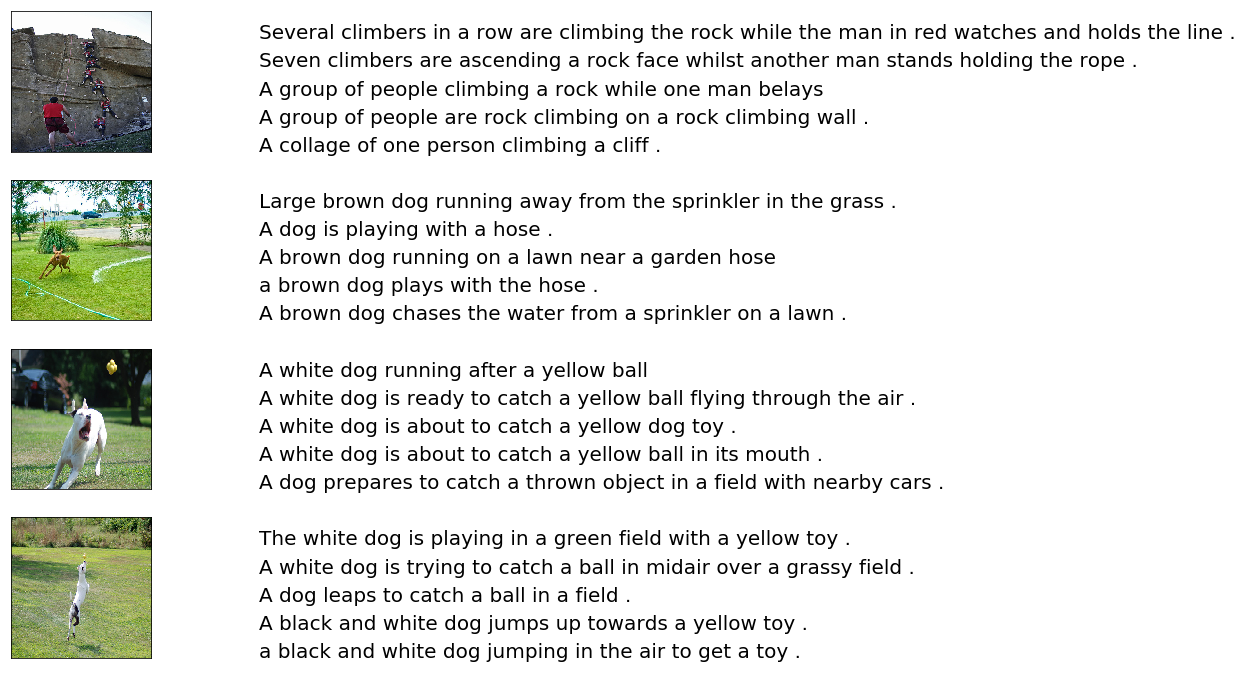

In [7]:
#calling the plot function to visualize the image and caption

fig = plt.figure(figsize=(10,15))
count = 1
    
for Path in df[60:80].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [8]:
#Create the vocabulary & the counter for the captions

vocabulary= []

for cap in df.Captions.values: 
    vocabulary.extend(cap.split())

val_count=Counter(vocabulary)

#val_count

In [9]:
#Visualise the top 30 occuring words in the captions

val_counts= pd.DataFrame.from_dict(val_count, orient= 'index').reset_index()
val_counts= val_counts.rename(columns= {'index': 'Phrase', 0: 'Occurance'})
val_counts.sort_values('Occurance', ascending= False, inplace= True)
val_counts.head()

,Phrase,Occurance
3,a,38716
15,.,34205
0,A,21480
2,in,18170
23,the,14587


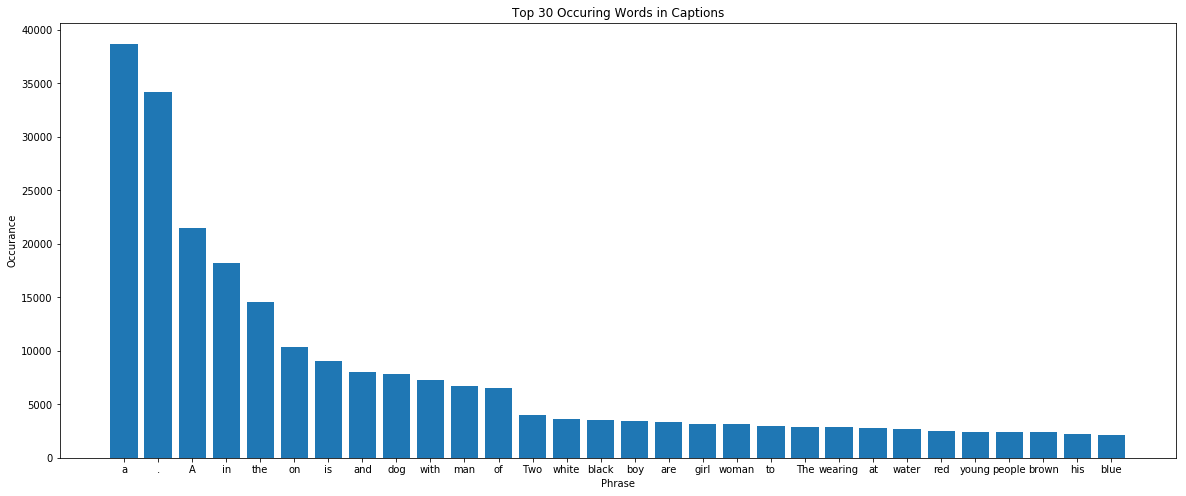

In [10]:
#Visualise the top 30 occuring words in the captions

top_30= val_counts.iloc[:30, :]

plt.figure(figsize= (20,8))
plt.bar(x= top_30.Phrase, height= top_30.Occurance)
plt.title('Top 30 Occuring Words in Captions')
plt.xlabel('Phrase')
plt.ylabel('Occurance')
plt.show()

In [11]:
#Create a list which contains all the captions
annotations= [] 

#add the <start> & <end> token to all those captions as well
for cap in df.Captions.values:
    anot= '<start> '+str(cap)+' <end>'
    annotations.append(anot)


#Create a list which contains all the path to the images
all_img_path= df.Path.to_list() 

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# create the tokenizer

top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(annotations)

In [13]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(annotations)

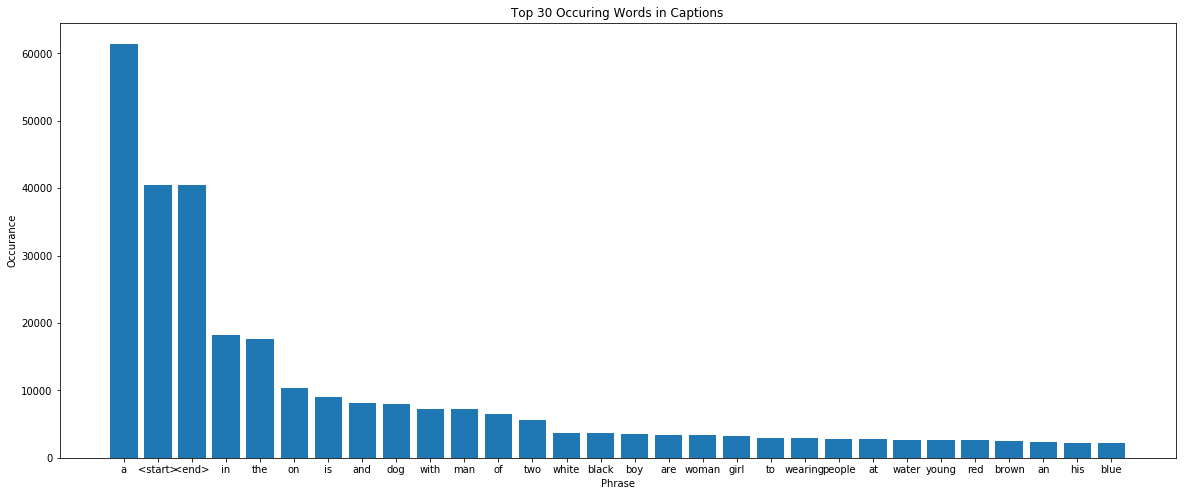

In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

val_counts= pd.DataFrame.from_dict(tokenizer.word_counts, orient= 'index').reset_index()
val_counts= val_counts.rename(columns= {'index': 'Phrase', 0: 'Occurance'})
val_counts.sort_values('Occurance', ascending= False, inplace= True)

top_30= val_counts.iloc[:30, :]

plt.figure(figsize= (20,8))
plt.bar(x= top_30.Phrase, height= top_30.Occurance)
plt.title('Top 30 Occuring Words in Captions')
plt.xlabel('Phrase')
plt.ylabel('Occurance')
plt.show()

In [15]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


In [97]:
# Find the maximum length of any caption in the dataset

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [98]:
# assigining the max_legnth variable

max_length = calc_max_length(train_seqs)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [16]:
# preprocessing the image by resizing to (299, 299) and normalizing to (-1, 1)

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [17]:
# creating the train and test data for both images and Captions

image_train, image_test, caption_train, caption_test= train_test_split(all_img_vector, cap_vector, train_size= 0.8, random_state= 42 )

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [18]:
# Initialize InceptionV3 and load the pretrained Imagenet weights

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#build the final model using both input & output layer

In [19]:
# code to extract features from each image in the dataset

encode_train = sorted(set(all_img_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

feature_dict= {}
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature]= bf.numpy()

506it [01:05,  2.87it/s]


In [20]:
# load the numpy files

def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

In [21]:
# defining function to Generate Dataset

BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [22]:
# creating train and test dataset

train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [23]:
# checking the sample image batches

sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [106]:
# setting the parameters for Model Building

embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE
attention_features_shape = 64

### Encoder

In [39]:
# defining class Encoder by using Sub classing method

class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [40]:
# calling the encoder class

encoder=Encoder(embedding_dim)

### Attention model

In [42]:
# defining class Attention model by using Sub classing method

class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [55]:
# defining class Decoder by using Sub classing method

class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [56]:
# calling decoder class

decoder=Decoder(embedding_dim, units, vocab_size)

In [57]:
# verifing the function calls for the shapes

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [58]:
# defining the optimizer and loss_object

optimizer = tf.keras.optimizers.Adam() 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

In [59]:
# defing loss_function object

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [61]:
# creating a checkpoint for the train model

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [62]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [71]:
# defining train_step

@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features= encoder(img_tensor)
        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [72]:
# defining test_step

@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [73]:
# calculating test_loss_cal

def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [74]:
# model training 

loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.267, & test loss is 1.073
Time taken for 1 epoch 212.41180801391602 sec

Test loss has been reduced from 100.000 to 1.073



 13%|█▎        | 2/15 [05:33<40:05, 185.07s/it]

For epoch: 2, the train loss is 0.996, & test loss is 0.952
Time taken for 1 epoch 120.52492427825928 sec

Test loss has been reduced from 1.073 to 0.952



 20%|██        | 3/15 [07:33<33:08, 165.69s/it]

For epoch: 3, the train loss is 0.907, & test loss is 0.879
Time taken for 1 epoch 120.33632016181946 sec

Test loss has been reduced from 0.952 to 0.879



 27%|██▋       | 4/15 [09:34<27:53, 152.10s/it]

For epoch: 4, the train loss is 0.842, & test loss is 0.819
Time taken for 1 epoch 120.27272439002991 sec

Test loss has been reduced from 0.879 to 0.819



 33%|███▎      | 5/15 [11:34<23:45, 142.54s/it]

For epoch: 5, the train loss is 0.788, & test loss is 0.768
Time taken for 1 epoch 120.13432693481445 sec

Test loss has been reduced from 0.819 to 0.768



 40%|████      | 6/15 [13:34<20:22, 135.88s/it]

For epoch: 6, the train loss is 0.741, & test loss is 0.724
Time taken for 1 epoch 120.22240781784058 sec

Test loss has been reduced from 0.768 to 0.724



 47%|████▋     | 7/15 [15:34<17:28, 131.04s/it]

For epoch: 7, the train loss is 0.699, & test loss is 0.682
Time taken for 1 epoch 119.61170625686646 sec

Test loss has been reduced from 0.724 to 0.682



 53%|█████▎    | 8/15 [17:33<14:52, 127.51s/it]

For epoch: 8, the train loss is 0.660, & test loss is 0.644
Time taken for 1 epoch 119.17089033126831 sec

Test loss has been reduced from 0.682 to 0.644



 60%|██████    | 9/15 [19:33<12:30, 125.04s/it]

For epoch: 9, the train loss is 0.624, & test loss is 0.609
Time taken for 1 epoch 119.13565564155579 sec

Test loss has been reduced from 0.644 to 0.609



 67%|██████▋   | 10/15 [21:32<10:16, 123.33s/it]

For epoch: 10, the train loss is 0.592, & test loss is 0.578
Time taken for 1 epoch 119.21265149116516 sec

Test loss has been reduced from 0.609 to 0.578



 73%|███████▎  | 11/15 [23:31<08:08, 122.13s/it]

For epoch: 11, the train loss is 0.561, & test loss is 0.549
Time taken for 1 epoch 119.23491168022156 sec

Test loss has been reduced from 0.578 to 0.549



 80%|████████  | 12/15 [25:30<06:03, 121.23s/it]

For epoch: 12, the train loss is 0.534, & test loss is 0.524
Time taken for 1 epoch 119.0218551158905 sec

Test loss has been reduced from 0.549 to 0.524



 87%|████████▋ | 13/15 [27:30<04:01, 120.65s/it]

For epoch: 13, the train loss is 0.509, & test loss is 0.500
Time taken for 1 epoch 119.16932129859924 sec

Test loss has been reduced from 0.524 to 0.500



 93%|█████████▎| 14/15 [29:29<02:00, 120.23s/it]

For epoch: 14, the train loss is 0.487, & test loss is 0.479
Time taken for 1 epoch 119.1495373249054 sec

Test loss has been reduced from 0.500 to 0.479



100%|██████████| 15/15 [31:28<00:00, 119.98s/it]

For epoch: 15, the train loss is 0.467, & test loss is 0.459
Time taken for 1 epoch 119.26257395744324 sec

Test loss has been reduced from 0.479 to 0.459


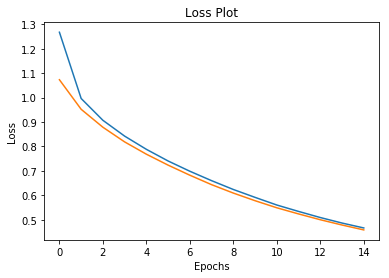

In [75]:
# plotting loss for different epochs

plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [120]:
# defining function for evaluating the predicted captions using Greedy Search

def evaluate(image):

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search

In [115]:
# defining function for evaluating the predicted captions using Beam Search

def beam_evaluate(image, beam_index = 3):
    
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [116]:
# defining the plot_attmap for plot the attention features

def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [118]:
# defining function to remoce the tags

def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 14.416787170305085
Real Caption: two brown and white dogs are next to each other with red toys in their mouths
Prediction Caption: two brown and white dog is being chased by side


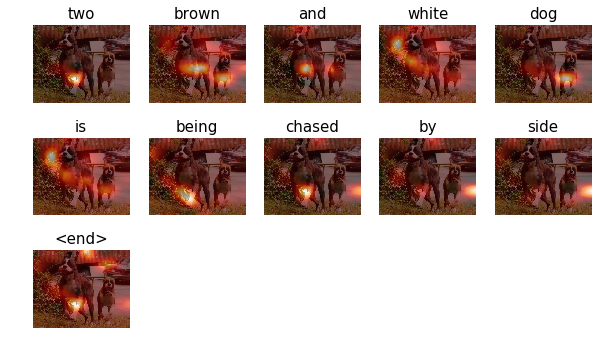

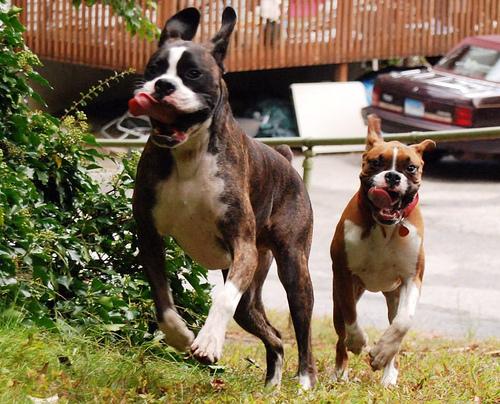

In [138]:
# taking a random image to check the real and predicted caption using greedy search

rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot, pred_test  = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25)) #set your weights)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

two brown and white dog to a field


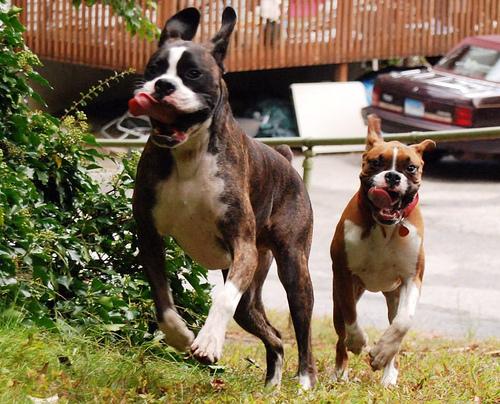

In [139]:
# taking a random image to check the real and predicted caption using beam search

captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)